# 게임 전적 사이트 크롤링

- 전체적인 코드흐름:
   셀레니움을 통해 전적갱신시간을 확인하여 몇시간 전 또는 몇일전에 마지막으로 업데이트가 되었다면 전적갱신 버튼을 눌러 데이터를 최신으로 불러옵니다   
   그후 맨아래쪽의 더보기 버튼을 눌러 총 100게의 기록을 불러올수있도록 4번(더보기 버튼을 누를때마다 20게의 기록을 추가로 불러옵니다. 최초 20개의 기록을 기본적으로 불러옴 20+20*4)을 누릅니다.
   html을 불러온후 beautifulsoup를 이용하여 원하는 정보를 뽑아
   판다스로 정리를 합니다

- 현제는 승률을 계산하는 것까지 구현 되어있습니다.



In [10]:
import re
import time
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By


# nickname = input('op.gg 사이트에서 검색할 닉네임을 입력해주세요 : \n')
url = f'https://www.op.gg/summoners/kr/hide on bush'

# Chrome 드라이버 경로 설정
driver = webdriver.Chrome()

# op.gg 웹 사이트로 이동
print('로딩중...')
driver.get(url)
try:

    look = driver.find_element(By.XPATH, '//*[@id="content-header"]/div[1]/div/div[1]/div[2]/div[6]/div').text
    print(look)
except:
    pass
if re.search(r'(시간|일)\s+전', look):
    driver.find_element(By.CSS_SELECTOR, ".css-1ki6o6m.e18vylim0").click()
    print('데이터 최신화 중...')
    new = tqdm(range(5),desc='5초 소요',leave=False)
    for i in new:
        time.sleep(1)
    new.close()
        

driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(0.5)

for i in range(1, 7):
    try:
        more_button = driver.find_element(By.XPATH, '//*[@id="content-container"]/div[2]/button')
        more_button.click()
        print('게임 로드중...')
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
    except:
        print("더이상 찾을 데이터가 없습니다.")
        break

    
print('완료')

html = driver.page_source
# print('파일저장중')
# f = open('/Users/dryoon/Documents/schoolproject/all.html','w')
# f.write(html)
# f.close() 
# print('저장완료!')
# driver.quit()





로딩중...
게임 로드중...
게임 로드중...
게임 로드중...
게임 로드중...
게임 로드중...
게임 로드중...
완료
파일저장중
저장완료!


## 간단 코드설명
- 위쪽 코드 :   
사이트에서 selenium을 이용하여 동적웹로딩후 html변수에 html 코드저장

- 아래쪽 코드 :   
beautifulsoup를 이용하여 코드 분석 및 판다스를 이용한 데이터 프레임 생성
matplotlib로 승률 파이차트 생성

가져온 게임의 판수는 120판 입니다
승리 : 73 판
패배 : 47 판
승률 : 60.83%
     결과
0    승리
1    패배
2    승리
3    승리
4    승리
..   ..
115  승리
116  패배
117  패배
118  승리
119  승리

[120 rows x 1 columns]


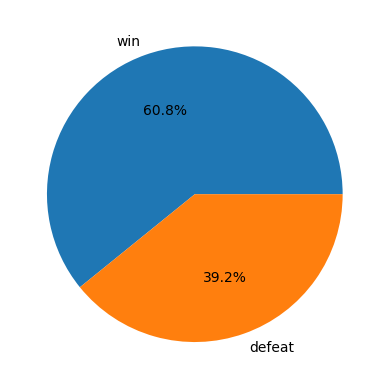

In [11]:
# # 파일 열기 (읽기 모드)
# file_path = "/Users/dryoon/Documents/schoolproject/all.html"  # 파일 경로를 지정합니다.
# file = open(file_path, "r")


soup = BeautifulSoup(html, 'html.parser')
# "game-content" 클래스 선택
game_content = soup.select('div.game-content')

#가져온 게임수 세기
recent_game_len = len(game_content)
print(f'가져온 게임의 판수는 {recent_game_len}판 입니다')

# 승패가져와서 데이터프레임으로 저장
result_all = soup.find_all(class_="result")
result_values = [result.get_text() for result in result_all]
df_result = pd.DataFrame({'결과': result_values})
#승리와 패베 개수샘
result_num = df_result['결과'].value_counts()

#kda 가져와서 데이터프레임으로 저장
result_kda = soup.find_all(class_="k-d-a")
kda_values = [kdaresult.get_text() for kdaresult in result_kda]
del kda_values[0]
df_kda = pd.DataFrame({'k/d/a': kda_values},index=None)

try:
    print(f"승리 : {result_num['승리']} 판")
    print(f"패배 : {result_num['패배']} 판")
    try:
        print(f"다시하기 : {result_num['다시하기']} 판")
    except:
        pass
    winrate = "%0.2f"%((result_num["승리"]/(result_num['승리']+result_num['패배']))*100)
    print(f'승률 : {winrate}%')
    print(df_result)
except:
    print(f'총게임수는{recent_game_len}입니다.')
    print('승률은 0%입니다')



# df_result.append({'승률': winrate})
# df_kda.append({'kda': '으아악'})

# df_result와 df_kda를 합칠 때 동일한 인덱스를 사용하고 싶다면
# 먼저 두 데이터프레임의 길이가 같은지 확인하고, 없으면 새로운 인덱스 생성
if len(df_result) != len(df_kda):
    df_result = df_result.reset_index(drop=True)
    df_kda = df_kda.reset_index(drop=True)



# 두 데이터프레임 합치기
merged_df = pd.concat([df_result, df_kda], axis=1)

# 결과를 엑셀 파일로 저장
merged_df.to_excel('merged_df.xlsx', index=False)

ratio = [result_num['승리'],result_num['패배']]
labels = ['win', 'defeat']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()